In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from keras import backend as K
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [ ]:
window_length = 10
encoding_dim = 3
epochs = 200
test_samples = 150

## Utils

In [ ]:
def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 15))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend();

## Datasets retrieval & transformation

In [ ]:
# get data
# df = pd.read_csv("datasets/nasdaq2007_17.csv", header=None, sep='\t')
df = pd.read_csv("https://raw.githubusercontent.com/DImiTrisXam/algo_project1/main/project3/datasets/nasd_input.csv", header=None, sep='\t')

df = df.iloc[0, 1:].to_frame("price").astype('float32')

df.head()

,price
1,40.130001
2,40.617001
3,40.119999
4,39.889999
5,40.130001


In [ ]:
scaler = MinMaxScaler()

x_train_nonscaled = np.array([df['price'].values[i-window_length:i].reshape(-1, 1)
                             for i in range(window_length+1, len(df['price']))])
x_train = np.array([scaler.fit_transform(df['price'].values[i-window_length:i].reshape(-1, 1))
                   for i in range(window_length+1, len(df['price']))])

x_test = x_train[-test_samples:]
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.shape)
print(x_test.shape)

(569, 10, 1)
(150, 10, 1)


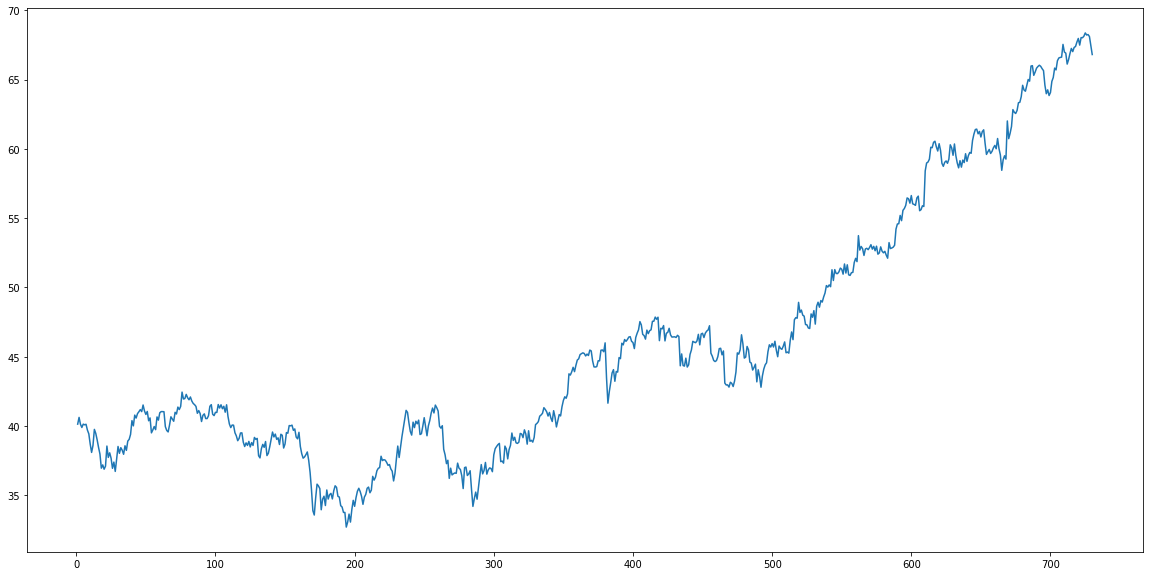

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(df.price)

In [ ]:
print("Percentage of test data: {}%".format((test_samples/len(x_train))*100))

Percentage of test data: 26.36203866432337%


## 1D Convolutional autoencoder

(569, 10, 1)
(569, 3, 256)
HELOOOOOOOOOOO [[67.47    ]
 [67.47    ]
 [67.47    ]
 ...
 [67.47    ]
 [67.47504 ]
 [67.474365]]
Epoch 1/200
5/5 [==============================] - 1s 95ms/step - loss: 0.6859 - val_loss: 0.6530
Epoch 2/200
5/5 [==============================] - 0s 49ms/step - loss: 0.6384 - val_loss: 0.5655
Epoch 3/200
5/5 [==============================] - 0s 53ms/step - loss: 0.5751 - val_loss: 0.5519
Epoch 4/200
5/5 [==============================] - 0s 56ms/step - loss: 0.5609 - val_loss: 0.5319
Epoch 5/200
5/5 [==============================] - 0s 59ms/step - loss: 0.5493 - val_loss: 0.5251
Epoch 6/200
5/5 [==============================] - 0s 59ms/step - loss: 0.5412 - val_loss: 0.5176
Epoch 7/200
5/5 [==============================] - 0s 58ms/step - loss: 0.5358 - val_loss: 0.5191
Epoch 8/200
5/5 [==============================] - 0s 59ms/step - loss: 0.5327 - val_loss: 0.5050
Epoch 9/200
5/5 [==============================] - 0s 58ms/step - loss: 0.5258 - val_loss:

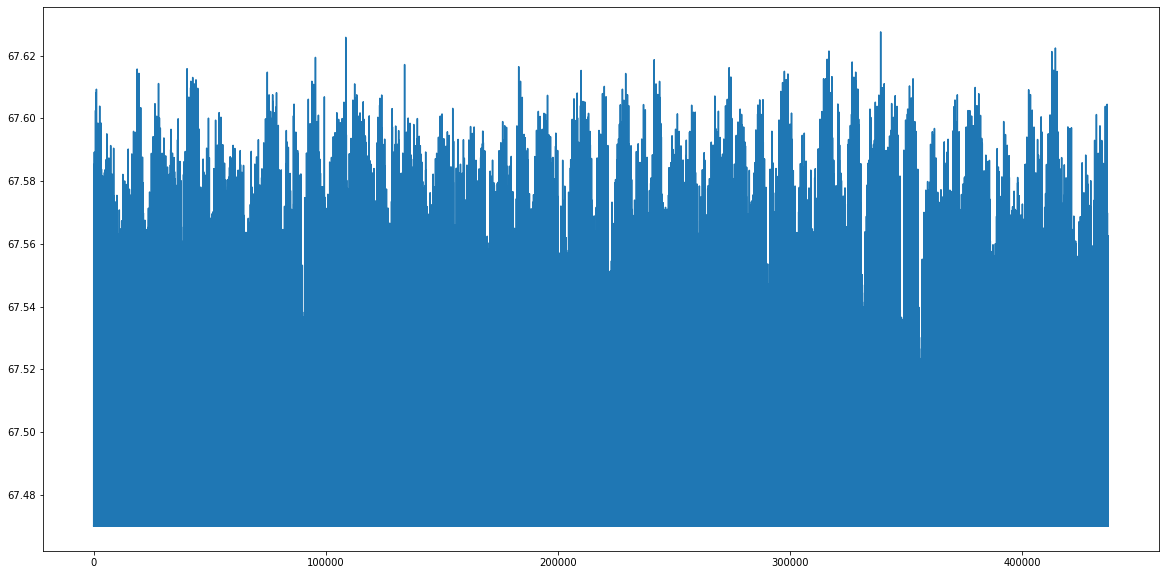

In [ ]:
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
input_window = Input(shape=(window_length, 1))

x = Conv1D(32, 3, activation="relu", padding="same")(input_window)  


x = Conv1D(64, 3, activation="relu", padding="same")(input_window) 
x = MaxPooling1D(2, padding="same")(x)  
x = Conv1D(128, 3, activation="relu", padding="same")(x)  
x = Conv1D(256, 3, activation="relu", padding="same")(x)  

encoded = MaxPooling1D(2, padding="same")(x)  

encoder = Model(input_window, encoded)

###################
encoded_series = encoder(x_train).numpy()
print(encoded_series.shape)
plt.figure(figsize=(20, 10))
reduced_price = encoded_series.flatten().reshape(-1,1)

reduced_price_scaled = scaler.inverse_transform(reduced_price)

plt.plot(reduced_price_scaled)
###################

x = Conv1D(256, 3, activation="relu", padding="same")(encoded)  
x = Conv1D(128, 3, activation="relu", padding="same")(encoded)  

x = UpSampling1D(2)(x) 
x = Conv1D(64, 2, activation='relu')(x)  

x = Conv1D(32, 1, activation='relu')(x)  
x = UpSampling1D(2)(x)  

decoded = Conv1D(1, 4, activation='sigmoid', padding='same')(x)  # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                          epochs=epochs,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

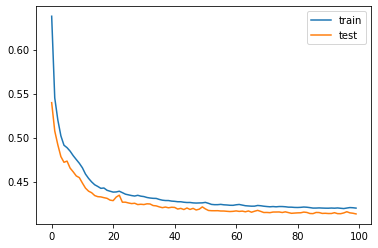

In [ ]:
plot_history(history)

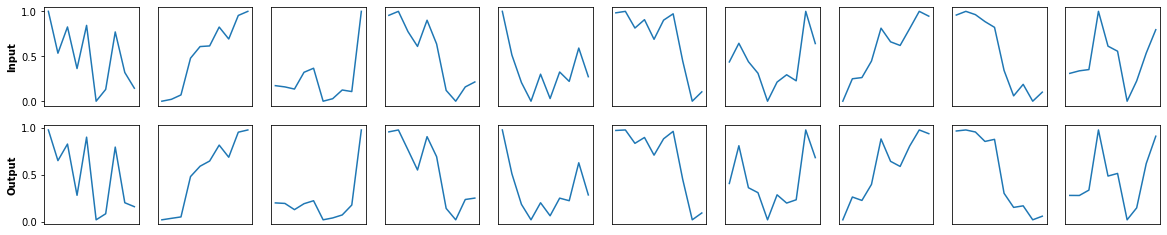

In [ ]:
plot_examples(x_test_deep, decoded_stocks)